In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
words = open('names.txt', 'r').read().splitlines()

In [6]:
# build mappings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [8]:
# build the dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            indx = stoi[ch]
            X.append(context)
            Y.append(indx)
            context = context[1:] + [indx]
                
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [9]:
n_embd = 10 # dimension of each character
n_hidden = 200 # number of nodes in hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g)*(5/3) / ((n_embd * block_size)**0.5) # *0.2
b1 = torch.randn(n_hidden, generator=g)*0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g)*0.01
b2 = torch.randn(vocab_size, generator=g)*0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


tensor(-0.0163) tensor(1.0039)
tensor(0.0007) tensor(1.0123)


(array([2.00299061e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 4.00598122e-05, 8.01196244e-05,
        2.00299061e-04, 2.20328967e-04, 4.40657934e-04, 7.21076620e-04,
        1.76263174e-03, 2.94439620e-03, 4.38654944e-03, 7.31091573e-03,
        1.31396184e-02, 1.89683211e-02, 3.30092853e-02, 5.00547353e-02,
        7.89578899e-02, 1.15913067e-01, 1.59037454e-01, 2.21430612e-01,
        2.94139171e-01, 3.63222317e-01, 4.08229516e-01, 4.30202323e-01,
        4.09831909e-01, 3.61219327e-01, 2.96943358e-01, 2.27539733e-01,
        1.69833574e-01, 1.19258061e-01, 7.98992954e-02, 5.20777559e-02,
        3.42110796e-02, 2.04505341e-02, 1.27790801e-02, 7.19073629e-03,
        4.28639991e-03, 2.64394761e-03, 1.44215324e-03, 7.21076620e-04,
        6.00897183e-04, 3.40508404e-04, 1.40209343e-04, 6.00897183e-05,
        2.00299061e-05, 6.00897183e-05]),
 array([-6.87284327, -6.62321653, -6.3735898 , -6.12396307, -5.87433634,
        -5.62470961, 

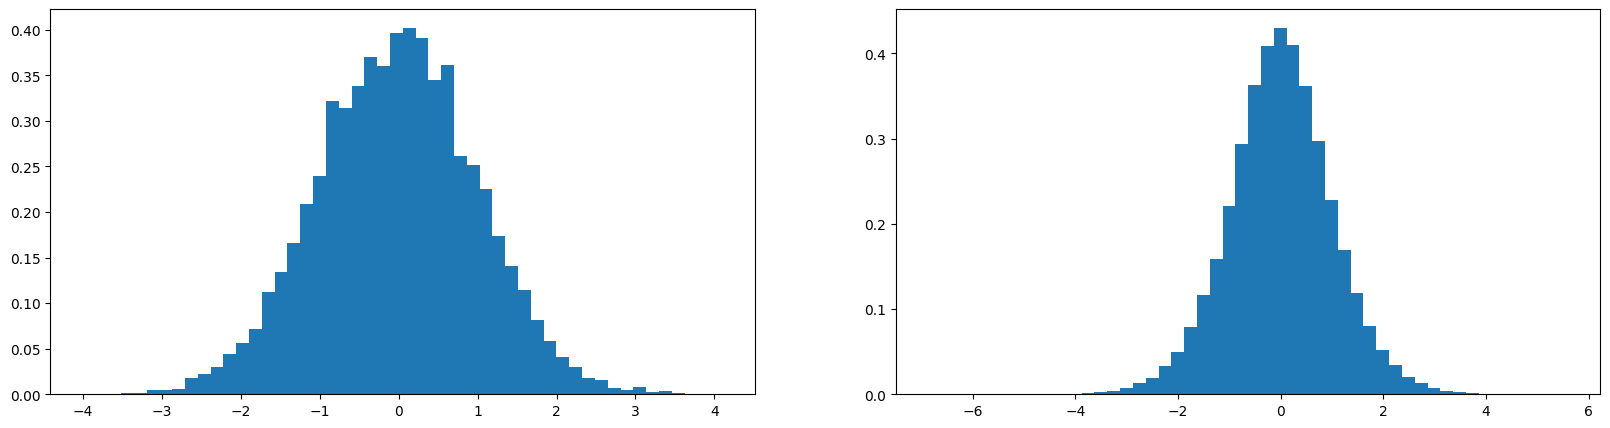

In [67]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)/10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)
# observe that standard deviation is high for y and low for x.
# to increase/decrease the standard deviation of y we have to increase/decrease
# the factor of multiplication of w. 
# To get a standard deviation of nearly 1 we should divide w by a factor of sqrt(number_samples)
# For ReLU it is sqrt(2/num_samples) because in ReLU it discards half of the space

torch.nn.init.kaiming_normal_()

In [16]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # mini-batch construction
    indx = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[indx], Ytr[indx]
    
    # forward pass
    emb = C[Xb] 
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1 # if too small tanh does nothing, if too large then tanh is saturated we want it to be roughly guassian
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain*(hpreact - bnmeani)/bnstdi + bnbias # haha we ended up not using b1 (but inplace we are using bnbias) i.e., b1.grad = 0 always
    
    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi
        
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i<100000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
    
    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    lossi.append(loss.log10().item())
#     break

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


Because of this high loss we keep wasting a lot of iterations to squash down the large weights we initialised with.

In [12]:
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([0., 0., 0., 0.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

In [13]:
logits = torch.tensor([0.0, 5.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([0., 5., 0., 0.]),
 tensor([0.0066, 0.9802, 0.0066, 0.0066]),
 tensor(5.0200))

In [19]:
logits = torch.randn(4)*100
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([154.5112, 124.6087, -93.9276, -98.1772]),
 tensor([1.0000e+00, 1.0315e-13, 0.0000e+00, 0.0000e+00]),
 tensor(inf))

Observe that loss keep increasing as randomness increased among the elements of the tensor which is meaningless.

In [8]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

(array([170., 206., 172., 144., 166., 133., 149., 126., 127., 121., 106.,
        109., 129.,  94., 128., 103., 109.,  86., 112.,  83., 100.,  75.,
         99.,  88.,  87., 112.,  83., 130., 115.,  95., 108., 106., 118.,
         94.,  99., 126.,  85., 126., 124., 113., 122., 120., 143., 158.,
        165., 192., 182., 176., 257., 229.]),
 array([-9.99114394e-01, -9.59151689e-01, -9.19188983e-01, -8.79226278e-01,
        -8.39263573e-01, -7.99300867e-01, -7.59338162e-01, -7.19375457e-01,
        -6.79412751e-01, -6.39450046e-01, -5.99487340e-01, -5.59524635e-01,
        -5.19561930e-01, -4.79599224e-01, -4.39636519e-01, -3.99673814e-01,
        -3.59711108e-01, -3.19748403e-01, -2.79785697e-01, -2.39822992e-01,
        -1.99860287e-01, -1.59897581e-01, -1.19934876e-01, -7.99721706e-02,
        -4.00094652e-02, -4.67598438e-05,  3.99159455e-02,  7.98786509e-02,
         1.19841356e-01,  1.59804062e-01,  1.99766767e-01,  2.39729472e-01,
         2.79692178e-01,  3.19654883e-01,  3.59617

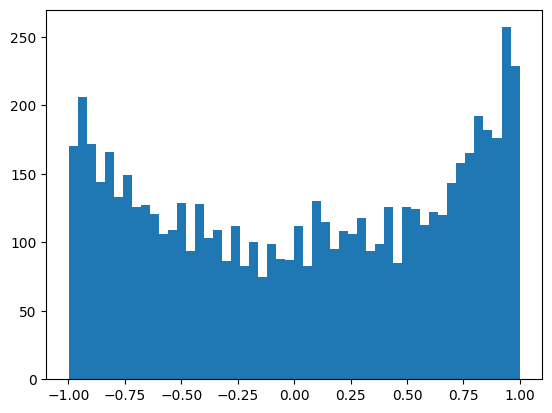

In [56]:
plt.hist(h.view(-1).tolist(), 50)

Observe that most of the values are in the extremes

(array([  2.,   3.,   1.,   2.,   2.,   1.,   6.,   8.,  13.,  26.,  37.,
         35.,  57.,  90., 120., 112., 136., 205., 221., 257., 275., 321.,
        362., 351., 320., 404., 386., 358., 338., 303., 265., 272., 243.,
        192., 126., 133., 125.,  90.,  53.,  32.,  28.,  25.,  19.,  15.,
          9.,   6.,   2.,  10.,   2.,   1.]),
 array([-3.86098313, -3.70754832, -3.5541135 , -3.40067869, -3.24724387,
        -3.09380906, -2.94037424, -2.78693943, -2.63350461, -2.48006979,
        -2.32663498, -2.17320016, -2.01976535, -1.86633053, -1.71289572,
        -1.5594609 , -1.40602609, -1.25259127, -1.09915646, -0.94572164,
        -0.79228683, -0.63885201, -0.48541719, -0.33198238, -0.17854756,
        -0.02511275,  0.12832207,  0.28175688,  0.4351917 ,  0.58862651,
         0.74206133,  0.89549614,  1.04893096,  1.20236578,  1.35580059,
         1.50923541,  1.66267022,  1.81610504,  1.96953985,  2.12297467,
         2.27640948,  2.4298443 ,  2.58327911,  2.73671393,  2.89014874,
 

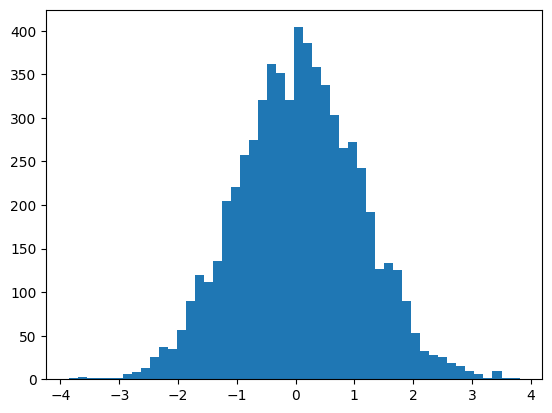

In [57]:
plt.hist(hpreact.view(-1).tolist(), 50)

This is because of the very broad range of hpreact we can see here.
And when the tanh value becomes 1 or -1, the gradient vanishes and hence it is not backpropagating.
hpreact beign too far from 0 is causing the issue.

torch.Size([32, 200])


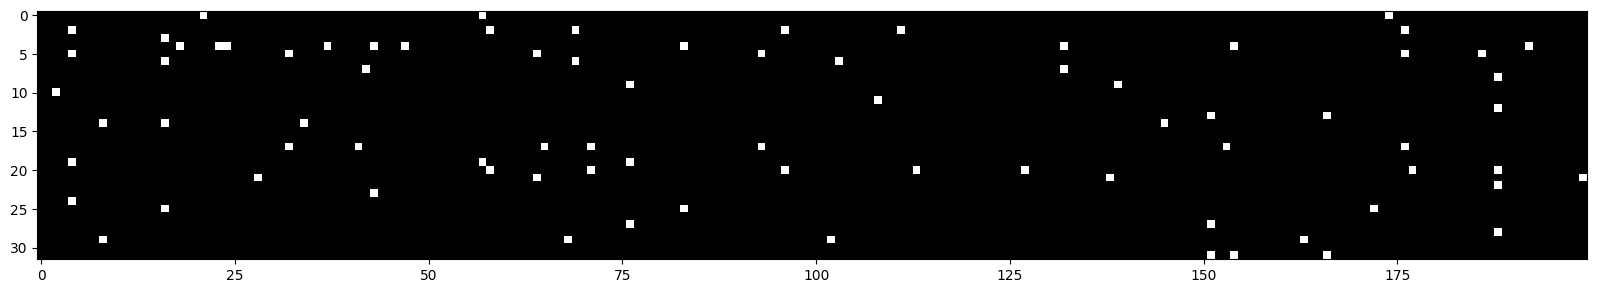

In [58]:
print(h.shape)
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') # white when true and black when false

a white space means that the neuron is not active i.e., is not effected by backpropagation.
A complete column of white means that the neuron/node is dead which should not happen. 

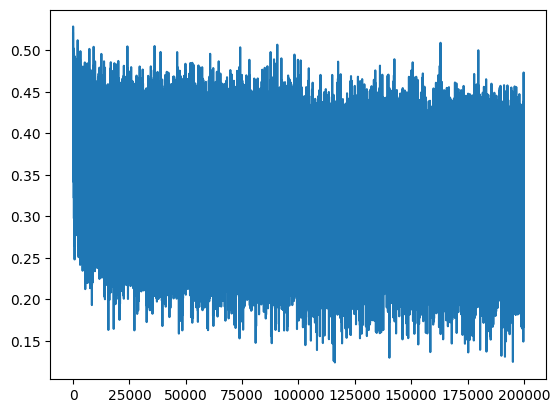

In [17]:
plt.plot(lossi)

In [20]:
# calibrate the batch norm at the end of training
# to get a fixed bnmean and bnstd

with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [18]:
bnmean, bnstd

(tensor([[-2.3355,  0.6776, -0.9133,  1.0163,  1.0866,  1.0938,  1.7436, -2.1208,
           0.5730,  1.4455, -1.6343, -2.7372, -0.4752, -0.1412, -0.0745, -1.1722,
           0.6851, -2.6219, -0.1065,  1.6325, -0.7706, -0.3063,  0.0479,  0.6115,
           1.1173,  0.2427,  2.0500,  0.5831,  0.8527,  1.7680, -0.3625, -0.8355,
          -0.0854, -0.5177, -0.3806, -1.0699, -0.0786,  0.3487, -0.5808,  0.9875,
          -0.4427, -1.3082, -0.2871, -0.2332,  0.6850,  0.6850,  2.0857, -0.7608,
           2.3866,  1.8734,  0.8259,  0.2803,  1.8898,  0.4709,  0.6739, -1.8940,
          -0.0401,  0.4338,  1.3760, -0.8910, -0.4524,  1.1754,  0.5613,  0.6051,
           1.5859,  1.2261, -1.0112,  2.1495, -0.6393,  0.0938, -0.2864, -0.4856,
           0.9632, -1.0461, -2.9990,  0.6391,  1.4327, -0.1590,  0.0941,  0.5253,
           0.2508,  1.2521,  2.0388,  0.6608,  0.0691, -0.0813, -1.6723,  0.2933,
           2.2423, -0.0211, -0.6666,  1.4253, -0.8412, -1.2248, -1.0129,  0.2230,
           0.211

In [19]:
bnmean_running, bnstd_running

(tensor([[-2.3539,  0.6872, -0.9000,  1.0159,  1.0894,  1.0862,  1.7389, -2.1356,
           0.5608,  1.4246, -1.6445, -2.7426, -0.4861, -0.1510, -0.0687, -1.1550,
           0.6891, -2.6399, -0.1283,  1.6240, -0.7732, -0.2865,  0.0467,  0.6119,
           1.1172,  0.2433,  2.0542,  0.5778,  0.8515,  1.7729, -0.3741, -0.8385,
          -0.0831, -0.5198, -0.3817, -1.0699, -0.0781,  0.3370, -0.5769,  0.9935,
          -0.4507, -1.3313, -0.2895, -0.2299,  0.6877,  0.6936,  2.0835, -0.7759,
           2.3804,  1.8613,  0.8117,  0.2735,  1.8802,  0.4705,  0.6656, -1.8962,
          -0.0420,  0.4356,  1.3924, -0.8906, -0.4676,  1.1688,  0.5539,  0.6000,
           1.5853,  1.2103, -1.0171,  2.1421, -0.6330,  0.1071, -0.2926, -0.4831,
           0.9506, -1.0144, -2.9925,  0.6268,  1.4404, -0.1574,  0.0955,  0.5159,
           0.2487,  1.2401,  2.0104,  0.6695,  0.0768, -0.0851, -1.6767,  0.2963,
           2.2374, -0.0100, -0.6669,  1.4356, -0.8431, -1.2317, -1.0220,  0.2201,
           0.192

In [21]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # hpreact = bngain*(hpreact - hpreact.mean(0, keepdim=True))/hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain*(hpreact - bnmean_running)/bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.06659197807312
val 2.1050572395324707


In [10]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        indx = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [indx]
        out.append(indx)
        if indx == 0:
            break
            
    print(''.join(itos[i] for i in out))

briangmyazziyes.
bdulyah.
briyas.
brdrner.
sherkodrlithlyllsenleigh.
santhannchyziohmkrrnn.
shdumrishimnest.
jadestly.
prgbdulfuubdgghder.
jaquezmashburjahsis.
dashby.
sadya.
sus.
zakquslutel.
subristia.
sumprrdnn.
quloeonandphillsamreyxa.
hunton.
bdasirfalvinnwrllwildtalfr.
tandysestss.


In [11]:
# batch-normalisation - standardize hidden states to be guassian only at initialization

In [12]:
# In batch-normalisation we start relating different exaples used in the mini-batch
# which is not there before. This as a side-effect is helping the neural network not to 
# over-fit and works as a regulariser by introducing noise to each particular example.

In [1]:
# torchifying 

In [57]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) /fan_in**0.5 # fan_in might not be needed when batch_normalised
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (we will change)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma *xhat + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size), 
]
# layers = [
#     Linear(n_embd*block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size), 
# ]

with torch.no_grad():
#     layers[-1].weight*=0.1
    layers[-1].gamma*=0.1
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight*=5/3 # for tanh this value exactly stabilises the activation if it less than this it will be zero faster otherwise it will be close to 1.
            # can be kept one when batch_normalised
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47551


In [58]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    #mini-batch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i<100000 else 0.01 # need to adjust accordingly for batch_normalised
    for p in parameters:
        p.data += -lr * p.grad
        
    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i>=1000:
        break

      0/ 200000: 3.2790


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.53%
layer 5 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 1.97%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 2.72%
layer 14 (      Tanh): mean -0.01, std 0.64, saturated: 2.06%


Text(0.5, 1.0, 'activation distribution')

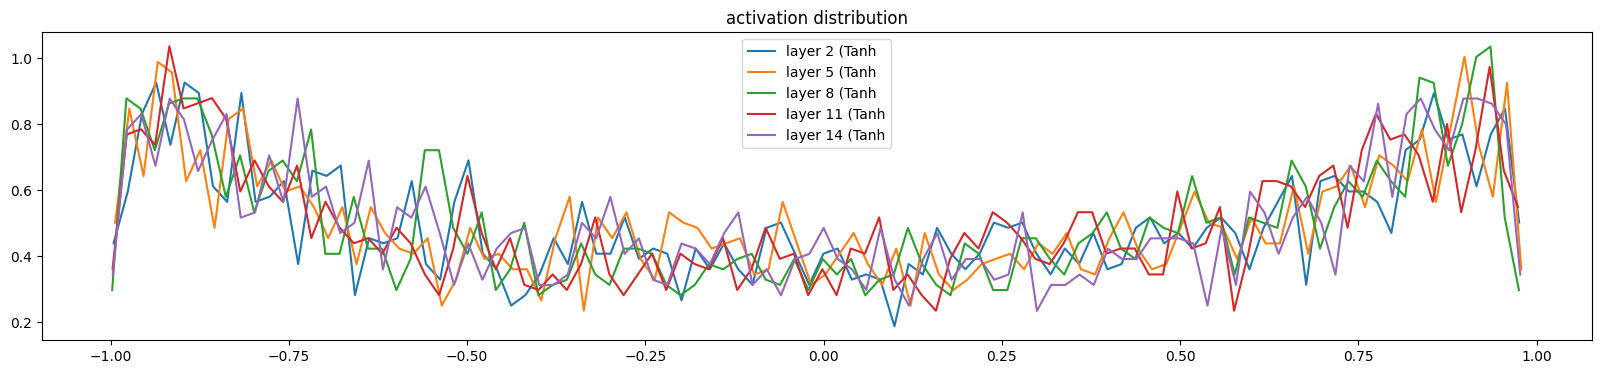

In [59]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs()>0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 4.146130e-03
layer 5 (      Tanh): mean -0.000000, std 3.471447e-03
layer 8 (      Tanh): mean -0.000000, std 3.097051e-03
layer 11 (      Tanh): mean -0.000000, std 2.819659e-03
layer 14 (      Tanh): mean +0.000000, std 2.673055e-03


Text(0.5, 1.0, 'gradient distribution')

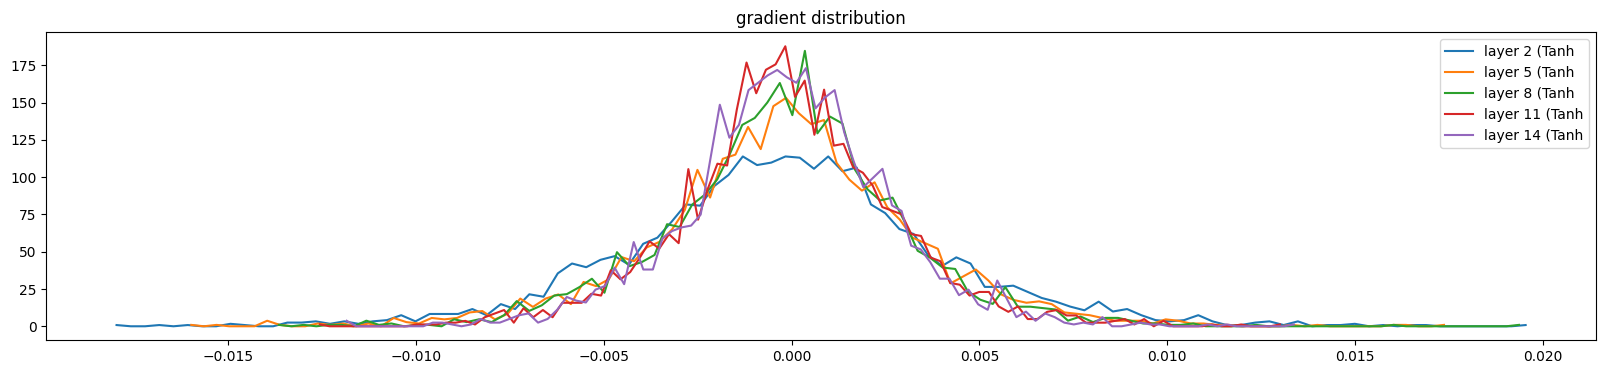

In [60]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.258775e-02 | grad:data ratio 1.257478e-02
weight  (30, 100) | mean +0.000054 | std 9.928169e-03 | grad:data ratio 3.188845e-02
weight (100, 100) | mean +0.000155 | std 8.597763e-03 | grad:data ratio 5.160581e-02
weight (100, 100) | mean +0.000077 | std 7.299912e-03 | grad:data ratio 4.325157e-02
weight (100, 100) | mean -0.000049 | std 6.680705e-03 | grad:data ratio 4.019876e-02
weight (100, 100) | mean -0.000050 | std 6.214481e-03 | grad:data ratio 3.706472e-02
weight  (100, 27) | mean +0.000034 | std 1.192147e-02 | grad:data ratio 6.962790e-02


Text(0.5, 1.0, 'weights gradient distribution')

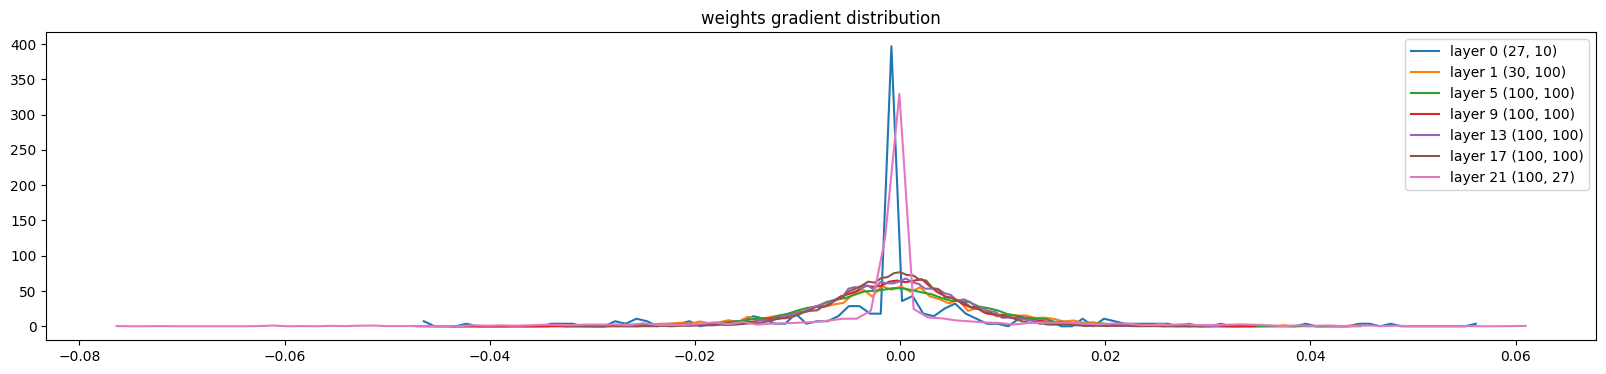

In [61]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

In [62]:
# Observe that the output layer is getting trained 10 times faster than other layers

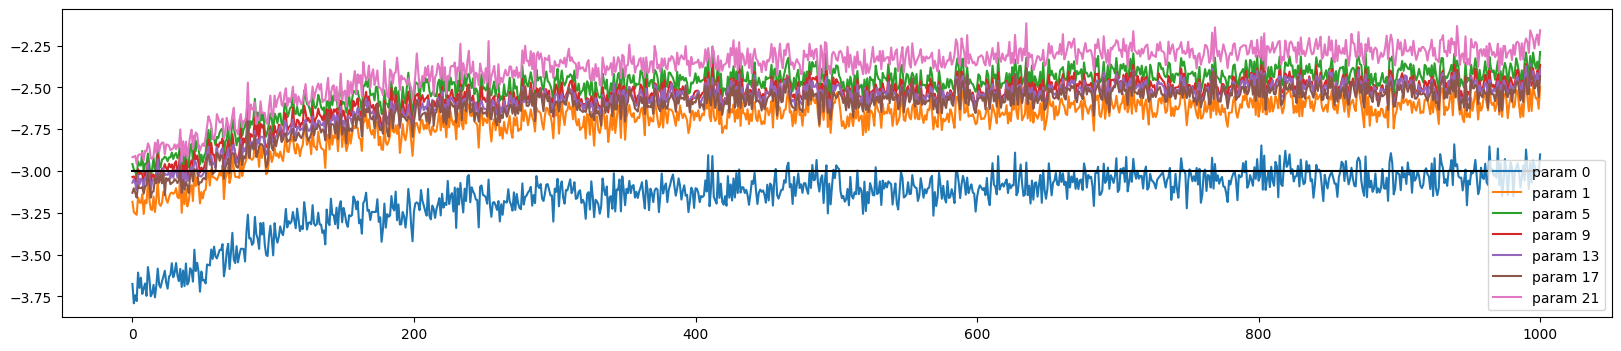

In [63]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') 
plt.legend(legends);
# because of initial shrinkage of the output layer weights we have done the value is initially high for the output layer
# later is learning

# if the ratio is less than -3 then the learning is not fast enough
# i.e., if lr = 0.001

In [64]:
# introducing batchnorm, 
# add the batchnorm layer in each level and remove the softmax shrinking of the last layer
# instead we will do that for gamma